# Week 07 Group 40

## Import necessary modules

In [8]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

## Load the dataset

In [9]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()
print("min = {}max = {}".format(input_train.min(),input_train.max()))

min = 0max = 255


## Print some images with their lables

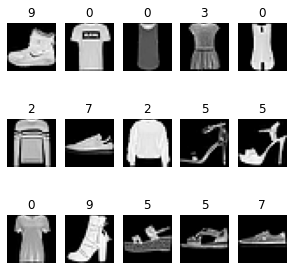

In [10]:
fig, ax = plt.subplots(3,5, figsize = (5,5))
ax = ax.flatten()
for i in range(15):

    # Readout an image and the corresponding label.
    img = input_train[i]
    lbl = label_train[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(label_train[i])
    ax[i].axis("off")

## Preprocess the data

In [23]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.mnist.load_data()
def preprocess(input, label):
    input = input/255
    input = tf.reshape(input,(28,28,1))
    print(input)
    label = tf.one_hot(label, 10)
    label = tf.reshape(label, (-1,))
    return (input, label)
#print(input_train.shape)
#print(label_train.shape)
#print(input_test.shape)
input_train = tf.data.Dataset.from_tensor_slices(input_train)
label_train = tf.data.Dataset.from_tensor_slices(label_train)
input_test = tf.data.Dataset.from_tensor_slices(input_test)
label_test = tf.data.Dataset.from_tensor_slices(label_test)
train_ds = tf.data.Dataset.zip((input_train, label_train)) 
test_ds = tf.data.Dataset.zip((input_test, label_test))
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
train_ds =   (tf.data.Dataset.shuffle(train_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)
test_ds =   (tf.data.Dataset.shuffle(test_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)

Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)
Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)


## Convolutional autoencoder

### Encoder

In [24]:
class Encoder(Model):            # tf.keras.layers.Layer
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv_layer1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu") #, input_shape = (28,28,1)
        self.pool_layer1 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")

        self.conv_layer2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")
        self.pool_layer2 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")

        self.conv_layer3 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")
        self.pool_layer3 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")
    
    def __call__(self, x, training):
        x = self.conv_layer1(x)
        x = self.pool_layer1(x)

        x = self.conv_layer2(x)
        x = self.pool_layer2(x)

        x = self.conv_layer3(x)
        x = self.pool_layer3(x)
        return x

### Decoder

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dense_layer = tf.keras.layers.Dense(units = 100, activation = None)

        self.conv_layer1 = tf.keras.layers.Conv2DTranspose(filters = 9  , kernel_size = 3, strides = 2, padding = "same", activation = None)
        self.conv_layer2 = tf.keras.layers.Conv2DTranspose(filters = 196, kernel_size = 3, strides = 2, padding = "same", activation = None)
        self.conv_layer3 = tf.keras.layers.Conv2DTranspose(filters = 34, kernel_size = 3, strides = 1, padding = "same", activation = None)

        #self.flat_layer2 = tf.keras.layers.Flatten()

        #self.dense_layer = tf.keras.layers.Dense(units = 784, activation = None)

        self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size= 3, padding = "same", activation = "sigmoid")

    def __call__(self, x, training):
        x = self.dense_layer(x)

        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        #x = self.flat_layer2(x)

        #x = self.dense_layer(x)

        x = self.output_layer(x)
        return x

###selftry mit conv2dtranspose

In [ ]:
# class Decoder(tf.keras.Model):
#     def ___init___(self):
#         super(Decoder, self).__init__()

#         self.flat_layer1 = tf.keras.layers.Flatten()

#         self.conv_layer1 = tf.keras.layers.Conv2DTranspose(filters = 9  , kernel_size = 3, strides = 2, padding = "valid", activation = None)
#         self.conv_layer2 = tf.keras.layers.Conv2DTranspose(filters = 196, kernel_size = 3, strides = 2, padding = "valid", activation = None)
#         self.conv_layer3 = tf.keras.layers.Conv2DTranspose(filters = 784, kernel_size = 3, strides = 2, padding = "valid", activation = None)

#         self.flat_layer2 = tf.keras.layers.Flatten()

#         self.dense_layer = tf.keras.layers.Dense(units = 784, activation = None)

#         self.output = tf.keras.layers.Dense(units = 1, activation = "sigmoid")

#     def call(self, x, training):
#         x = self.flat_layer1(x)

#         x = self.conv_layer1(x)
#         x = self.conv_layer2(x)
#         x = self.conv_layer3(x)

#         x = self.flat_layer2(x)

#         x = self.dense_layer(x)

#         x = self.output(x)
#         return x

### Autoencoder

In [21]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()

        self.decoder = Decoder()

        #self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size= 3, padding = "same")

    def __call__(self, x, training):
        x = self.encoder(x, training)

        x = self.decoder(x, training)
        
        #x = self.output_layer(x)
        return x

##ResNet

### Actual ResNet model

In [ ]:
class ResNet(tf.keras.Model):
    def __init__(self):
        # inherit information from the higher class
        super(ResNet, self).__init__()

        # implement the order with increasing numbers of filters
        self.conv_layer1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = None)
        self.norm_layer1 = tf.keras.layers.BatchNormalization()
        self.activation_layer1 = tf.keras.layers.ReLU()

        self.res_block1 = ResidualBlock(num_filters = [64,64,64])

        self.conv_layer2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 2, strides = 2, padding = "valid", activation = None)
        self.norm_layer2 = tf.keras.layers.BatchNormalization()
        self.activation_layer2 = tf.keras.layers.ReLU()
        self.dropout_layer1 = tf.keras.layers.Dropout(0.5)

        self.res_block2 = ResidualBlock(num_filters = [128,128,128])

        # one more residual block for experimentation
        #self.conv_layer3 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 2, strides = 2, padding = "valid", activation = None)
        #self.norm_layer3 = tf.keras.layers.BatchNormalization()
        #self.activation_layer3 = tf.keras.layers.ReLU()
        #self.dropout_layer2 = tf.keras.layers.Dropout(0.5)

        #self.res_block3 = ResidualBlock(num_filters = [256,256,256])

        self.globalpooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_layer1 = tf.keras.layers.Dense(units=128, activation = None) 
        self.norm_layer4 = tf.keras.layers.BatchNormalization() 
        self.activation_layer4 = tf.keras.layers.ReLU()
        self.output_layer = tf.keras.layers.Dense(units=10, activation = tf.keras.activations.softmax)
      
    def call(self, x, training = True):
        x = self.conv_layer1(x)
        x = self.norm_layer1(x, training = training)
        x = self.activation_layer1(x)
        x = self.res_block1(x)

        x = self.conv_layer2(x)
        x = self.norm_layer2(x, training = training)
        x = self.activation_layer2(x)
        x = self.dropout_layer1(x, training = training)
        x = self.res_block2(x)

        #x = self.conv_layer3(x)
        #x = self.norm_layer3(x, training)
        #x = self.activation_layer3(x)
        #x = self.dropout_layer2(x, training)
        #x = self.res_block3(x)

        x = self.globalpooling_layer(x)
        x = self.dense_layer1(x)
        x = self.norm_layer4(x, training = training)
        x = self.activation_layer4(x)
        x = self.output_layer(x)
        return x

## Define training and test step

In [16]:
def train_step(model, input, target, loss_function, optimizer, training = True):
    with tf.GradientTape() as tape:
        expectation = model(input, training)
        train_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        loss = loss_function(target, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

def test(model, test_data, loss_function, training_bool = False):
    test_accuracies_total = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model( input, training_bool)
        test_loss = loss_function(target, expectation)
        test_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        test_accuracy = np.mean(test_accuracy)
        test_accuracies_total.append(test_accuracy)
        test_losses_total.append(test_loss)
    
    # take the mean of all losses and all accuracies to get them for the whole test
    test_losses_total = np.mean(test_losses_total)
    test_accuracies_total = np.mean(test_accuracies_total)
    return test_losses_total, test_accuracies_total

## Train the Model for 20 epochs

In [22]:
num_epochs = 20
learning_rate = 0.0001
# use categorical crossentropy as loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()
# use adam as optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# initialize the model
model = Autoencoder()

# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []


# get loss on train data before training
train_loss, train_accuracy = test(model, train_ds, loss_function)
train_loss_list.append(train_loss)
train_accuracy_list.append(train_accuracy)

# test once before training
test_loss, test_accuracy = test(model, test_ds, loss_function)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)


# we train for the predefined number of epochs
for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    train_accuracy_agg = []
    # train the model with the training data
    for (input, target) in train_ds:
        # perform training step and store the loss and accuracy of step
        train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
        changing_average.append(train_loss)
        train_accuracy_agg.append(np.mean(train_accuracy))

    # compute mean loss and accuracy of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    train_accuracy_list.append(np.mean(train_accuracy_agg))
    
    # test on the test data
    test_loss, test_accuracy = test(model, test_ds, loss_function)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print("Epoch: " + str(step + 1))
    print("Training Accuracy: " + str(train_accuracy_list[step + 1]))
    print("Test Accuracy: " + str(test_accuracy_list[step + 1]))

ValueError: ignored

## Take a look at the accuracy and loss during training and on the test data

In [ ]:
print(train_accuracy_list)
print(train_loss_list)
print(test_accuracy_list)
print(test_loss_list)

[0.10016384271099744, 0.4016544117647059, 0.5136468989769821, 0.560701726342711, 0.5926510549872123, 0.6158687659846548, 0.6352901214833759, 0.6534726662404092, 0.6693973785166241, 0.6805266943734015, 0.6918358375959079, 0.7029851342710998, 0.7083599744245525, 0.7191296355498721, 0.7257432864450127, 0.733076246803069, 0.7397898017902813, 0.7431265984654731, 0.7522778132992327, 0.7533168158567775, 0.7632872442455243]
[2.307847, 1.6550399, 1.3470131, 1.2247547, 1.1407185, 1.0772247, 1.0240102, 0.9756641, 0.93462145, 0.9026489, 0.8700294, 0.84066594, 0.82347554, 0.7989013, 0.7735225, 0.75790447, 0.74005765, 0.722516, 0.70430124, 0.6936497, 0.67293525]
[0.1009156050955414, 0.41878980891719747, 0.457703025477707, 0.4762141719745223, 0.5490644904458599, 0.5272691082802548, 0.5327428343949044, 0.5380175159235668, 0.5934514331210191, 0.5767316878980892, 0.5664808917197452, 0.5992237261146497, 0.6529657643312102, 0.6183320063694268, 0.6270899681528662, 0.6509753184713376, 0.6571457006369427, 0.

## Plot the results

###selftry ohne maxpooling

In [ ]:
# class Encoder(tf.keras.Model):
#     def __init__(self):
#         super(Encoder, self).__init__()


#         # number of filters = input size of image (28 x 28 = input size 784)
#         self.conv_layer1 = tf.keras.layers.Conv2D(filters = 784, kernel_size = 3, strides = 2, padding = "valid", activation = None)
#         self.conv_layer2 = tf.keras.layers.Conv2D(filters = 196, kernel_size = 3, strides = 2, padding = "valid", activation = None)
#         self.conv_layer3 = tf.keras.layers.Conv2D(filters = 9  , kernel_size = 3, strides = 2, padding = "valid", activation = None)

#         self.flat_layer = tf.keras.layers.Flatten()

#         self.dense_layer = tf.keras.layers.Dense(units = 10, activation = None)

#     def step(self, x, training):
#         x = self.conv_layer1(x)
#         x = self.conv_layer2(x)
#         x = self.conv_layer3(x)

#         x = self.flat_layer(x)

#         x = self.dense_layer(x)
#         return x

In [ ]:
class Decoder(Model):            # tf.keras.layers.Layer
    def __init__(self):
        super(Decoder, self).__init__()
        print("sas")
        self.conv_layer1 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")
        self.upsample1 = tf.keras.layers.UpSampling2D(size = 2)

        self.conv_layer2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")
        self.upsample2 = tf.keras.layers.UpSampling2D(size = 2)

        self.conv_layer3 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "valid", activation = "relu")
        self.upsample3 = tf.keras.layers.UpSampling2D(size = 2)

        self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, padding = "same", activation = "sigmoid")

    def __call__(self, x, training):
        x = self.upsample1(x)
        x = self.conv_layer1(x)

        x = self.upsample2(x)
        x = self.conv_layer2(x)

        x = self.dense_layer(x)

        x = self.output(x)
        return x

In [ ]:
d = Decoder()
#d.conv_layer1

sas


In [ ]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encode_layer = Encoder()
        self.decode_layer = Decoder()


    def __call__(self, x, training):
        x = self.encode_layer(x, training)

        x = self.decode_layer(x, training)
        return x

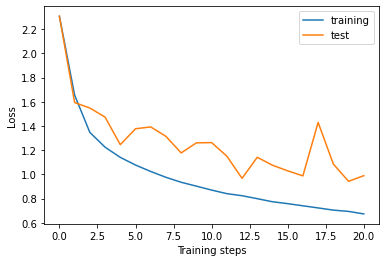

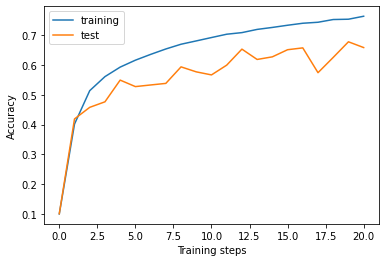

In [ ]:
# Plot Figure displaying test and training loss for each epoch
plt.figure()
line1, = plt.plot(train_loss_list)
line2, = plt.plot(test_loss_list)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot Figure displaying test and training accuracy for each epoch
plt.figure()
line1, = plt.plot(train_accuracy_list)
line2, = plt.plot(test_accuracy_list)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()